In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import strat_models
from sklearn.metrics import auc

np.random.seed(0)

In [2]:
def joint_cov_prox(Y, nu, theta, t):
    """
    Proximal operator for joint covariance estimation
    """
    if Y is None:
        return nu

    n, nk = Y[0].shape
    Yemp = Y[0]@Y[0].T
    
    s, Q = np.linalg.eigh(nu/(t*nk)-Yemp/nk)
    w = ((t*nk)*s + np.sqrt(((t*nk)*s)**2 + 4*(t*nk)))/2
    return Q @ np.diag(w) @ Q.T

class covariance_max_likelihood_loss(strat_models.Loss):
    """
    f(theta) = Trace(theta @ Y) - logdet(theta)
    """
    def __init__(self):
        super().__init__()
        self.isDistribution = True

    def evaluate(self, theta, data):
        assert "Y" in data
        return np.trace(theta @ data["Y"]) - np.linalg.slogdet(theta)[1]

    def setup(self, data, G):
        Y = data["Y"]
        Z = data["Z"]

        K = len(G.nodes())

        shape = (data["n"], data["n"])
        theta_shape = (K,) + shape

        #preprocess data
        for y, z in zip(Y, Z):
            vertex = G._node[z]
            if "Y" in vertex:
                vertex["Y"] += [y]
            else:
                vertex["Y"] = [y]

        Y_data = []
        for i, node in enumerate(G.nodes()):
            vertex = G._node[node]
            if 'Y' in vertex:
                Y = vertex['Y']
                Y_data += [Y]
                del vertex['Y']
            else:
                Y_data += [None]

        cache = {"Y": Y_data, "n":data["n"], "theta_shape":theta_shape, "shape":shape, "K":K}
        return cache

    def prox(self, t, nu, warm_start, pool, cache):
        """
        Proximal operator for joint covariance estimation
        """
        res = pool.starmap(joint_cov_prox, zip(cache["Y"], nu, warm_start, t*np.ones(cache["K"])))
        return np.array(res)

    def logprob(self, data, G):
        
        logprobs = []
        
        for y,z in zip(data["Y"], data["Z"]):
            n, nk = y.shape
            
            Y = (y@y.T)/nk
            
            if (np.zeros((n,n)) == Y).all():
#                 logprobs += [0]
                continue            
            
            theta = G._node[z]["theta"]
            logprobs += [np.linalg.slogdet(theta)[1] - np.trace(Y@theta)]

        return logprobs

    def sample(self, data, G):
        Z = turn_into_iterable(data["Z"])
        sigmas = [np.linalg.inv(G._node[z]["theta"]) for z in Z]

        n = sigmas[0].shape[0]
        return [np.random.multivariate_normal(np.zeros(n), sigma) for sigma in sigmas]
    
class trace_offdiagL1Norm(strat_models.Regularizer):
    """
    r(theta) = lambd_0 * Tr(theta) + lambd_1 * || theta ||_{off diagonal, 1}
    """
    def __init__(self, lambd=(1,1)):
#         super().__init__(lambd)
        self.lambd = lambd
    
    def evaluate(self, theta):
        od_idx = np.where(~np.eye(theta.shape[0],dtype=bool))
        
        return self.lambd[0]*np.trace(theta) + self.lambd[1]*np.norm(theta[od_idx], 1)
    
    def prox(self, t, nu, warm_start, pool):
        if self.lambd == (0,0):
            return nu
        
        K = nu.shape[0]
        n = nu.shape[1]
        
        diag_idx = np.where(np.eye(n,dtype=bool))
        od_idx = np.where(~np.eye(n,dtype=bool))
        
        T = np.zeros((K, n, n))

        for k in range(K):
            T[k][diag_idx] = nu[k][diag_idx] - self.lambd[0]*t
            T[k][od_idx] = np.maximum(nu[k][od_idx] - self.lambd[1]*t, 0) - np.maximum(-nu[k][od_idx] - self.lambd[1]*t, 0)
        
        return T
        

In [3]:
n = 30
K_range = 10
K_azimuth = 10
K_doppler = 10
K = K_range * K_azimuth * K_doppler

print("n = {}".format(n))

print("K_range = {}".format(K_range))
print("K_azimuth = {}".format(K_azimuth))
print("K_doppler = {}".format(K_doppler))

print("K = {}".format(K_range * K_azimuth * K_doppler))

n = 30
K_range = 10
K_azimuth = 10
K_doppler = 10
K = 1000


In [4]:
ranges = [x for x in np.linspace(35e3, 50e3, K_range)] #meters
azimuths = [x for x in np.linspace(87, 267, K_azimuth)] #Radians
dopplers = [x for x in np.linspace(-992, 992, K_doppler)] #Hz

dict_ranges = {}
for k in range(K_range):
    dict_ranges[k] = ranges[k]

G_range = nx.relabel_nodes(nx.path_graph(K_range), dict_ranges)

dict_azimuths = {}
for k in range(K_azimuth):
    dict_azimuths[k] = azimuths[k]
    
G_azimuth = nx.relabel_nodes(nx.cycle_graph(K_azimuth), dict_azimuths)

dict_dopplers = {}
for k in range(K_doppler):
    dict_dopplers[k] = dopplers[k]

G_doppler = nx.relabel_nodes(nx.path_graph(K_doppler), dict_dopplers)

G = strat_models.cartesian_product([G_range, G_azimuth, G_doppler])

nodelist = G.nodes()

In [5]:
L = nx.laplacian_matrix(G).A
np.sum(L != 0)

6600

In [6]:
def generate_data_experiment_1():
    Z = []
    S_trues = dict()

    Y_train, Y_test = [], []
    
    psd_doppler = np.random.randn(n,n)
    psd_doppler = psd_doppler @ np.conj(psd_doppler).T / (n) + 2*np.random.rand(n)*np.eye(n)

    psd_azimuth = 2*np.random.randn(n,n)
    psd_azimuth = psd_azimuth @ np.conj(psd_azimuth).T / (n) + np.random.rand(n)*np.eye(n)

    psd_range = np.random.randn(n,n)
    psd_range = psd_range @ np.conj(psd_range).T / (n) + 2*np.random.rand(n)*np.eye(n)

    NUM_SAMPLES_TRAIN = []
    NUM_SAMPLES_TEST = []
    
    for node in G.nodes():
        RANGE, AZIMUTH, DOPPLER = node

        S_true = (1+DOPPLER/1000)*psd_doppler
        S_true += (np.cos(np.pi*AZIMUTH/180)+np.sin(np.pi*AZIMUTH/180))*psd_azimuth
        S_true += ((4e4 / RANGE)**2)*psd_range
        
        S_trues[node] = S_true

        num_samples_node_train = np.random.choice(list(range(n//(3))) + [0]*(n) + [1]*(n//3) + [n])
        num_samples_node_test = np.random.choice(list(range(1, n//11+1)) + [n] + [1]*300 + [2]*10)
        
        NUM_SAMPLES_TRAIN += [num_samples_node_train]
        NUM_SAMPLES_TEST += [num_samples_node_test]

        y_train = np.random.multivariate_normal(np.zeros(n), np.real(S_true), num_samples_node_train).T
        y_test = np.random.multivariate_normal(np.zeros(n), np.real(S_true), num_samples_node_test).T
        
        if num_samples_node_train == 0:
            y_train = np.zeros((n,1))

        Z += [node]

        Y_train += [y_train]
        Y_test += [y_test]

    data_train = dict(Y=Y_train, Z=Z, n=n)
    data_test = dict(Y=Y_test, Z=Z, n=n)
    
    #for common
    data_train_common = dict(Y=Y_train, Z=[0]*len(Y_train), n=n)
    data_test_common = dict(Y=Y_test, Z=[0]*len(Y_test), n=n)
    
    return data_train, data_test, data_train_common, data_test_common, S_trues, NUM_SAMPLES_TRAIN, NUM_SAMPLES_TEST

In [7]:
"""EXPERIMENT 1"""

data_train, data_test, data_train_common, data_test_common, S_trues, NUM_SAMPLES_TRAIN, NUM_SAMPLES_TEST = generate_data_experiment_1()

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: covariance is not positive-semidefinite.
/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: covariance is not positive-semidefinite.


In [8]:
##Statistics about training samples

print("Number of vertices with no training samples:", sum(np.array(NUM_SAMPLES_TRAIN) == 0))
print("Max number of training samples per vertex:", max(NUM_SAMPLES_TRAIN))
print("Mean number of training samples per vertex:", np.mean(NUM_SAMPLES_TRAIN))

Number of vertices with no training samples: 625
Max number of training samples per vertex: 30
Mean number of training samples per vertex: 1.743


In [9]:
"""Common model"""
min_anll = np.inf
argmin_gamma = (np.inf, np.inf)
weights = np.logspace(np.log10(1e-3), np.log10(1e3), 100)
kwargs = dict(verbose=True, abs_tol=1e-4, maxiter=100)

Y_train_common = []
for (y,z) in zip(data_train["Y"], data_train["Z"]):
    if abs(np.sum(y)) <= 1e-9:
        continue
    Y_train_common += [y]

dict(Y=np.hstack(Y_train_common), Z=[0], n=n)    

gamma = (0.001, 59.6)
print("\t Common model, local weights = ", gamma)

G = nx.empty_graph(1)

loss = covariance_max_likelihood_loss()
reg = trace_offdiagL1Norm(lambd=gamma)

bm = strat_models.BaseModel(loss=loss, reg=reg)
common = strat_models.StratifiedModel(bm, graph=G)

info = common.fit(data_train_common, **kwargs)

anll = common.anll(data_test_common)/sum(NUM_SAMPLES_TEST)
print("RESULTS OF COMMON MODEL:")
print("\t\t Info: ", info)
print("\t\t Test ANLL: ", anll)   


	 Common model, local weights =  (0.001, 59.6)
 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 3.8117e+00 3.8041e+00 8.0543e-03 8.0543e-03 1.000 12.777 0.240 84.969
  2 | 6.7669e-01 3.7453e+00 7.9880e-03 8.2324e-03 1.000 7.231 0.105 72.499
  3 | 1.2268e+00 2.8594e+00 7.1021e-03 7.8486e-03 1.000 6.455 0.093 99.680
  4 | 1.2532e+00 2.1661e+00 6.4087e-03 8.1272e-03 1.000 5.308 0.079 102.334
  5 | 1.2726e+00 1.7266e+00 5.9692e-03 8.9795e-03 1.000 5.136 0.084 98.706
  6 | 1.3366e+00 1.4268e+00 5.6694e-03 1.0123e-02 1.000 5.892 0.087 99.336
  7 | 1.3966e+00 1.2032e+00 5.6393e-03 1.1415e-02 1.000 5.362 0.084 98.650
  8 | 1.4410e+00 1.0296e+00 5.6837e-03 1.2792e-02 1.000 6.640 0.087 95.379
  9 | 1.4694e+00 8.9498e-01 5.7120e-03 1.4215e-02 1.000 4.823 0.081 96.389
 10 | 1.4834e+00 7.9400e-01 5.7260e-03 1.5661e-02 1.000 4.913 0.085 94.984
 11 | 1.4849e+00 7.2285e-01 5.7275e-03 1.7112e-02 1.000 4.943 0.081 97.536
 12 | 1.4757e+00 6.7736e-01 5.7183e-03 1.8556e-0

In [10]:
"""Stratified model"""
kwargs = dict(verbose=True, abs_tol=1e-4, maxiter=500)

min_anll = np.inf
argmin_gamma = (np.inf, np.inf)
weights_gam1 = np.logspace(np.log10(1e-3), np.log10(1e3), 50)
weights_gam2 = np.logspace(np.log10(1e-3), np.log10(1e0), 50)
range_weights = np.logspace(np.log10(1e-2), np.log10(1e3), 100)
azimuth_weights = np.logspace(np.log10(1e-2), np.log10(1e3), 100)
doppler_weights = np.logspace(np.log10(1e-2), np.log10(1e3), 100)

gamma = (2.68, 0.66)
wt_range, wt_azimuth, wt_doppler = (10.52, 34.30, 86.97)

print("\t Stratified model, local weights = ", gamma)
print("\t (r,a,d) weights = ", (wt_range, wt_azimuth, wt_doppler))

strat_models.set_edge_weight(G_range, wt_range)
strat_models.set_edge_weight(G_azimuth, wt_azimuth)
strat_models.set_edge_weight(G_doppler, wt_doppler)
G = strat_models.cartesian_product([G_range, G_azimuth, G_doppler])

loss = covariance_max_likelihood_loss()
reg = trace_offdiagL1Norm(lambd=gamma)

bm = strat_models.BaseModel(loss=loss, reg=reg)
sm = strat_models.StratifiedModel(bm, graph=G)

info = sm.fit(data_train, **kwargs)

anll = sm.anll(data_test)/sum(NUM_SAMPLES_TEST)
print("RESULTS OF STRATIFIED MODEL:")
print("\t\t Info: ", info)
print("\t\t Test ANLL: ", anll)   

	 Stratified model, local weights =  (2.68, 0.66)
	 (r,a,d) weights =  (10.52, 34.3, 86.97)
 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 4.7731e+02 1.8875e+02 6.1147e-01 6.1147e-01 1.000 454.954 28.510 676.319
  2 | 2.4873e+02 5.2961e+01 3.8289e-01 8.5987e-01 1.000 1109.179 29.883 734.407
  3 | 9.6237e+01 1.3923e+02 2.7340e-01 9.5292e-01 1.000 1216.955 31.084 729.059
  4 | 4.6851e+01 1.1349e+02 2.4765e-01 9.3859e-01 1.000 1100.005 29.772 713.582
  5 | 7.2368e+01 4.7515e+01 2.0653e-01 8.9064e-01 1.000 757.034 33.760 737.574
  6 | 5.6279e+01 5.1284e+00 1.9044e-01 8.6041e-01 1.000 1123.237 30.226 735.333
  7 | 3.2199e+01 2.6693e+01 1.6636e-01 8.5276e-01 2.000 1245.251 30.134 727.978
  8 | 2.4251e+01 3.1203e+01 1.6537e-01 8.7171e-01 2.000 1168.621 28.469 738.674
  9 | 2.2460e+01 2.2112e+01 1.5662e-01 9.0159e-01 2.000 1266.852 30.553 744.555
 10 | 2.1018e+01 1.1522e+01 1.5518e-01 9.3206e-01 2.000 1046.213 30.240 737.712
 11 | 1.9383e+01 3.8263e+00 1.53

102 | 9.4932e-01 1.8924e-01 1.3511e-01 2.2491e+00 4.000 1089.685 28.829 731.907
103 | 9.2686e-01 1.8353e-01 1.3509e-01 2.2516e+00 4.000 1337.966 28.756 729.763
104 | 9.0502e-01 1.7795e-01 1.3507e-01 2.2540e+00 4.000 1613.087 30.005 726.284
105 | 8.8382e-01 1.7259e-01 1.3505e-01 2.2564e+00 4.000 1426.513 28.827 726.443
106 | 8.6316e-01 1.6740e-01 1.3503e-01 2.2587e+00 4.000 1245.411 28.463 727.120
107 | 8.4320e-01 1.6240e-01 1.3501e-01 2.2610e+00 4.000 1152.875 28.448 734.520
108 | 8.2379e-01 1.5755e-01 1.3499e-01 2.2632e+00 4.000 1147.211 29.351 729.083
109 | 8.0488e-01 1.5295e-01 1.3497e-01 2.2653e+00 4.000 1154.143 28.842 732.116
110 | 7.8650e-01 1.4847e-01 1.3495e-01 2.2674e+00 4.000 1097.074 28.661 727.446
111 | 7.6861e-01 1.4411e-01 1.3493e-01 2.2694e+00 4.000 1133.496 30.930 731.023
112 | 7.5123e-01 1.3990e-01 1.3492e-01 2.2714e+00 4.000 1073.653 34.364 731.314
113 | 7.3430e-01 1.3584e-01 1.3490e-01 2.2733e+00 4.000 1074.207 28.438 733.423
114 | 7.1783e-01 1.3193e-01 1.3488e-01 2

In [11]:
for model, model_type in zip([sm], ["Stratified"]):
    divergences = []
    for node in sm.G.nodes():
        divergences += [np.trace(S_trues[node]@model.G._node[node]["theta"]) - np.linalg.slogdet(model.G._node[node]["theta"])[1]]
    
    avg_divergence = np.mean(divergences)/n
    print(model_type, avg_divergence)

divergences = []
for node in sm.G.nodes():
    divergences += [np.trace(S_trues[node]@common.G._node[0]["theta"]) - np.linalg.slogdet(common.G._node[0]["theta"])[1]]
avg_divergence = np.mean(divergences)/n
print("Common", avg_divergence)

Stratified 1.6203289616587575
Common 2.018051183819809


In [12]:
print(ranges)
print(azimuths)
print(dopplers)

[35000.0, 36666.666666666664, 38333.333333333336, 40000.0, 41666.666666666664, 43333.333333333336, 45000.0, 46666.66666666667, 48333.333333333336, 50000.0]
[87.0, 107.0, 127.0, 147.0, 167.0, 187.0, 207.0, 227.0, 247.0, 267.0]
[-992.0, -771.5555555555555, -551.1111111111111, -330.66666666666663, -110.22222222222217, 110.22222222222217, 330.66666666666674, 551.1111111111113, 771.5555555555557, 992.0]


In [13]:
#this is the radar experiment
#n == 30, so that means that JP = n.
#J = number of radar elements
#P = number of pulses

J = 5
P = 3

fc = 1240e6 # carrier frequency, in hz
fR = 1984 # pulse repetition frequency, in hz

zs_t = []
for ft in dopplers:
    zs_t += [np.exp(1j*2*np.pi*ft/fR)]

zs_s = []
for phi_t in azimuths:
    zs_s += [np.exp(1j*2*np.pi*np.sin(phi_t))]
    
ss_s = [np.array([z**i for i in range(J)]) for z in zs_s]
ss_t = [np.array([z**i for i in range(P)]) for z in zs_t]

Ss = dict()
for ran in ranges:
    for (azi, ss) in zip(azimuths,ss_s):
        for (dop, st) in zip(dopplers, ss_t):
            s = np.kron(st, ss)
            Ss[ran, azi, dop] = np.concatenate([np.real(s), np.imag(s)])

In [14]:
#randomly pick a range/azi/dop combo and associate it with
np.random.seed(0)

num_per_node = 1
alpha=1.5

Ys = dict()
for node in S_trues.keys():
    ys_node = []
    for _ in range(num_per_node):
        interference_noise = np.random.multivariate_normal(np.zeros(n), np.real(S_trues[node]))
        if np.random.rand() <= 0.5:
            ys_node += [(interference_noise + alpha*Ss[node], "TARGET")] #corresponds to Ss[azi, dop]
        else:
            ys_node += [(interference_noise, "NOISE")]
    Ys[node] = ys_node

/Users/jonathantuck/opt/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


COMMON AUC-ROC: 0.844624
COMMON AUC-ROC: 0.9500960000000002


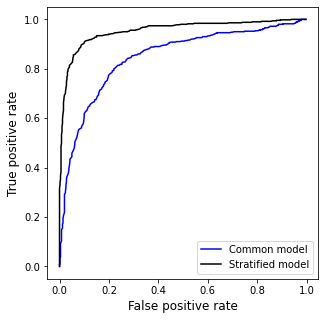

In [15]:
common_ROC = []
strat_ROC = []

theta_common = common.G._node[0]["theta"]

for thresh in np.logspace(-4,5,1000):
    tp_common = 0
    fp_common = 0
    
    tp_strat = 0
    fp_strat = 0
    
    tot_pos = 0
    tot_neg = 0
    for node in list(sm.G.nodes()):
        s = Ss[node]
        theta_z = sm.G._node[node]["theta"]
        
        for (y, istar) in Ys[node]:
            if istar == "TARGET":
                tot_pos += 1
            else:
                tot_neg += 1
            #common        
            stat_common = abs(s.T@theta_common@y)**2/(s.T@theta_common@s)
            if stat_common > thresh and istar == "TARGET":
                tp_common += 1
            if stat_common > thresh and istar == "NOISE":
                fp_common += 1
        
            #strat
            stat_sm = abs(s.T@theta_z@y)**2/(s.T@theta_z@s)
            if stat_sm > thresh and istar == "TARGET":
                tp_strat += 1
            if stat_sm > thresh and istar == "NOISE":
                fp_strat += 1
                
    common_ROC += [(fp_common/tot_neg, tp_common/tot_pos)]
    strat_ROC += [(fp_strat/tot_neg, tp_strat/tot_pos)]

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot([c[0] for c in common_ROC], [c[1] for c in common_ROC], label="Common model", color="blue")
ax.plot([c[0] for c in strat_ROC], [c[1] for c in strat_ROC], label="Stratified model", color="black")
ax.set_xlabel("False positive rate", fontsize="large")
ax.set_ylabel("True positive rate", fontsize="large")
ax.set_aspect(1.0)
ax.legend()

AUC_ROC_common = auc([c[0] for c in common_ROC], [c[1] for c in common_ROC])
AUC_ROC_strat = auc([c[0] for c in strat_ROC], [c[1] for c in strat_ROC])
print("COMMON AUC-ROC:", AUC_ROC_common)
print("COMMON AUC-ROC:", AUC_ROC_strat)